# Classification of cartilage integrity based on NIR spectroscopy

In [1]:
'''
Author: Isaac Afara, Ph.D.
        Department of Applied Physics
        University of Eastern Finland
        Kuopio, Finland.   
Date:   18th October, 2018
Update: 4th December, 2018

'''

from __future__ import print_function

# data analysis and wrangling
import itertools
import numpy as np
from scipy.signal import savgol_filter
import pandas as pd
from time import time

# visualization
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, cohen_kappa_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, f1_score 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# deep learning
from keras.models import Sequential, load_model
from keras.optimizers import Adam, SGD
from keras.layers import Dense, Conv1D, Dropout, Flatten, Activation, Reshape, BatchNormalization
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.initializers import he_uniform
from keras import backend as K
from tensorflow.python.keras.callbacks import TensorBoard


# general
import warnings
warnings.filterwarnings('ignore')  


print(__doc__)

Using TensorFlow backend.



Author: Isaac Afara, Ph.D.
        Department of Applied Physics
        University of Eastern Finland
        Kuopio, Finland.   
Date:   18th October, 2018
Update: 4th December, 2018




In [2]:
# Helper function plotting confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


## Import dataset

Import, prepare and visualize data

In [14]:
# Load dataset
data = pd.read_csv('spectra/nir_data.csv')

print('Size of data:',data.shape)

Size of data: (313, 246)


In [4]:
data.head()

,animals,integrity,943.05,949.6,956.15,962.7,969.25,975.8,982.35,988.89,...,2447,2453.3,2459.7,2466,2472.4,2478.7,2485.1,2491.4,2497.8,2504.1
0,2ACL_M1,A,0.82626,0.80473,0.95486,1.0691,0.90253,1.0026,0.95292,1.0308,...,2.2142,2.9081,3.5259,1.5544,4.0,1.4224,4.0,4.0000,2.0955,4.0
1,2ACL_M1,A,1.15140,1.35400,1.26280,1.2574,0.96724,0.9738,1.14060,1.1324,...,1.5519,4.0000,3.2685,1.4490,4.0,2.2590,4.0,3.1079,3.1036,4.0
2,2ACL_M1,A,0.94335,1.01790,1.09350,1.1432,0.91946,1.0490,1.00390,1.1941,...,4.0000,4.0000,4.0000,1.3116,4.0,3.3926,4.0,4.0000,3.3799,4.0
3,2ACL_M1,A,0.74013,0.97118,1.04990,1.1016,0.87052,1.0221,1.06960,1.0621,...,3.4203,4.0000,2.8129,1.9655,4.0,3.0725,4.0,4.0000,4.0000,4.0
4,2ACL_M1,A,1.07810,1.12220,1.25060,1.3822,0.98677,1.1179,1.11730,1.0746,...,3.4618,3.4040,4.0000,2.7526,4.0,2.8342,4.0,4.0000,1.0453,4.0


In [15]:
# Extract animals as list
names = data['animals'].unique().tolist() 

print('There are:',len(names),'unique animals, with the 1st and last animals ==>>', 
      names[0], 'and', names[-1],'.')

There are: 45 unique animals, with the 1st and last animals ==>> 2ACL_M1 and 8C_M4_right .


In [16]:
names = pd.DataFrame(data=names)
names

,0
0,2ACL_M1
1,2ACL_M1_CL
2,2ACL_M2
3,2ACL_M2_CL
4,2ACL_M3
5,2ACL_M3_CL
6,2ACL_M4
7,2ACL_M4_CL
8,2ACL_M5
9,2ACL_M6


### Sample groups in list

List indices for the following samples (**Note: deduct 1 to index**): 

|Sample      |  animal indices|
|------------|-----------|
|2 weeks ACLT (a2) | 1,3,5,7,9,10,12,14,16|
|2 weeks CL (c2)   | 2,4,6,8,11,13,15,17|
|2 weeks CNTRL (n2)| 18,19,20,21,22,23,24,25|
                 |                       |
|8 weeks ACLT (a8)| 26,28,30,32,34,36|
|8 weeks CL (c8)| 27,29,31,33,35,37|
|8 weeks CNTRL (n8)| 38,39,40,41,42,43,44,45|

In [17]:
# Split data by animals
data_grouped = dict(tuple(data.groupby('animals')))

list_data_grouped = [data_grouped[x] for x in data_grouped]

### Aim 1: Can we distinguish between CL and CNTRL samples based solely on NIR spectra

Here, we investigate the capacity of NIR spectroscopy to distinguish between CL and CNTRL samples. The samples are divided into training (80%) and test (20%) animals.

In [18]:
# Divide data into training and test animals by list indices
# Training animals
#CL
train_idx_c2 = [2,4,6,13,15,17]
train_idx_c8 = [29,31,33,35,37]
# CNTRL
train_idx_n2 = [18,19,20,21,22,23,25]
train_idx_n8 = [38,39,40,41,42,43]

# Test animals
#CL
test_idx_c2 = [8,11] 
test_idx_c8 = [27] 
# CNTRL
test_idx_n2 = [24] 
test_idx_n8 = [44,45] 

In [19]:
# Concatenate data from the samples

train_c2 = pd.DataFrame(columns=data.columns)
for x in train_idx_c2:
    train_c2 = train_c2.append(list_data_grouped[x-1], ignore_index=True)   
    
train_c8 = pd.DataFrame(columns=data.columns)
for x in train_idx_c8:
    train_c8 = train_c8.append(list_data_grouped[x-1], ignore_index=True)      
    
    
train_n2 = pd.DataFrame(columns=data.columns)
for x in train_idx_n2:
    train_n2 = train_n2.append(list_data_grouped[x-1], ignore_index=True)

train_n8 = pd.DataFrame(columns=data.columns)
for x in train_idx_n8:
    train_n8 = train_n8.append(list_data_grouped[x-1], ignore_index=True)
    
    
test_c2 = pd.DataFrame(columns=data.columns)
for x in test_idx_c2:
    test_c2 = test_c2.append(list_data_grouped[x-1], ignore_index=True) 
    
test_c8 = pd.DataFrame(columns=data.columns)
for x in test_idx_c8:
    test_c8 = test_c8.append(list_data_grouped[x-1], ignore_index=True) 
    
    
test_n2 = pd.DataFrame(columns=data.columns)
for x in test_idx_n2:
    test_n2 = test_n2.append(list_data_grouped[x-1], ignore_index=True)

test_n8 = pd.DataFrame(columns=data.columns)
for x in test_idx_n8:
    test_n8 = test_n8.append(list_data_grouped[x-1], ignore_index=True)

In [20]:
print('Sizes of 2 and 8 weeks CL training samples ==>>',train_c2.shape,'and',train_c8.shape)
print('Sizes of 2 and 8 weeks CNTRL training samples ==>>',train_n2.shape,'and',train_n8.shape)
print('Sizes of 2 and 8 weeks CL test samples ==>>',test_c2.shape,'and',test_c8.shape)
print('Sizes of 2 and 8 weeks CNTRL test samples ==>>',test_n2.shape,'and',test_n8.shape)

Sizes of 2 and 8 weeks CL training samples ==>> (41, 246) and (35, 246)
Sizes of 2 and 8 weeks CNTRL training samples ==>> (47, 246) and (42, 246)
Sizes of 2 and 8 weeks CL test samples ==>> (14, 246) and (7, 246)
Sizes of 2 and 8 weeks CNTRL test samples ==>> (7, 246) and (15, 246)


In [21]:
# Combine training and test samples for different comparison groups

train = pd.concat([train_c2,train_c8,train_n2,train_n8],axis=0,ignore_index=True)
test = pd.concat([test_c2,test_c8,test_n2,test_n8],axis=0,ignore_index=True)

print('Size of training sets:',train.shape)
print('Size of test sets:',test.shape)

Size of training sets: (165, 246)
Size of test sets: (43, 246)


In [22]:
# Extract spectra and labels

X_train = train.drop(['animals','integrity'], axis=1)
X_test = test.drop(['animals','integrity'], axis=1)

y_train = train['integrity']
y_test = test['integrity']


print('Training feature and label dimension CL_CNTRL==>>',X_train.shape, y_train.shape)

Training feature and label dimension CL_CNTRL==>> (165, 244) (165,)


In [23]:
# Create feature list (i.e., column names)

wavelength = X_train.columns

# Convert list to numpy array: necessary for data visualization
wave = []
for x in range(len(wavelength)):
    wave.append(float(wavelength[x]))
    
wave = np.array(wave, dtype=float)  
wave.shape


(244,)

In [ ]:
# Let's visualize some spectra
num_plots = 15
train_features = train_features.values
test_features = test_features.values

for x in range(num_plots):
    plt.plot(wave,train_features[x,:],'r')
    
for x in range(num_plots):
    plt.plot(wave,test_features[x,:],'b')
    
plt.xlabel('Wavelength (nm)')
plt.ylabel('Absorbance (AU)')
plt.title('Spectral plots of some training and test rabbit samples')
plt.show()


In [24]:
'''
Let's apply some smoothing filter of:
    - window_length = 9 
    - polynomial_degree = 2
    - Use the defaults for all other parameters.
'''

X_train_sm = savgol_filter(X_train, 9, 2, deriv=0, axis=0)
X_test_sm = savgol_filter(X_test, 9, 2, deriv=0, axis=0)

X_train_d1 = savgol_filter(X_train, 9, 2, deriv=1, axis=0)
X_test_d1 = savgol_filter(X_test, 9, 2, deriv=1, axis=0)

X_train_sm.shape

(165, 244)

In [ ]:
# Let's visualize the smoothed spectra
num_plots = 15

for x in range(num_plots):
    plt.plot(wave,train_features_sm[x,:],'r')
    
for x in range(num_plots):
    plt.plot(wave,test_features_sm[x,:],'b')
    
plt.xlabel('Wavelength (nm)')
plt.ylabel('Absorbance (AU)')
plt.title('Smoothed spectral plots of some training and test rabbit samples')
plt.show()

In [25]:
# Trim spectra: 1000 - 1900 nm
a = np.where(wave == 995.43)
b = np.where(wave == 1899.5)
print(a[0][0], b[0][0])

X_train_sm = X_train_sm[:,a[0][0]:b[0][0]]
X_test_sm = X_test_sm[:,a[0][0]:b[0][0]]

X_train_d1 = X_train_d1[:,a[0][0]:b[0][0]]
X_test_d1 = X_test_d1[:,a[0][0]:b[0][0]]

wave_trim = wave[a[0][0]:b[0][0]]

print(X_train_sm.shape, X_train_d1.shape)

8 148
(165, 140) (165, 140)


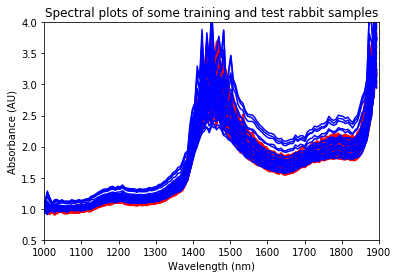

In [106]:
# Let's visualize the trimmed spectra
num_plots = 35

for x in range(num_plots):
    plt.plot(wave_trim,X_train_sm[x,:],'r')
    
for x in range(num_plots):
    plt.plot(wave_trim,X_test_sm[x,:],'b')
    
plt.xlim(right=1900, left=1000)
plt.ylim(top=4, bottom=0.5)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Absorbance (AU)')
plt.title('Spectral plots of some training and test rabbit samples')
plt.show()

In [26]:
# Convert test labels into array for modeling

le = preprocessing.LabelEncoder()
le.fit(y_train)
print('label classes ==>>',le.classes_)

y_train_label = le.transform(y_train)
y_test_label = le.transform(y_test)

y_test_label

label classes ==>> ['C' 'N']


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

## Create Classification Models

The following algorithms will be used to develop models for classification of ACLT and CNTRL cartilage samples from their NIR spectra. The models' their hyper-parameters will be tuned using with GridSearchCV.

- Support Vector Classifier 
    1. With smoothed features
    2. With dimension-reduced latent variables
 
 
- Logistic Regression


- Deep Learning Classifier

    

## 1. Support Vector Classification

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}

Grid scores on development set:

0.270 (+/-0.007) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.270 (+/-0.007) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.270 (+/-0.007) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.270 (+/-0.007) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.538 (+/-0.461) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.270 (+/-0.007) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.646 (+/-0.391) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.538 (+/-0.461) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.608 (+/-0.406) for {'C': 1, 'kernel': 'linear'}
0.626 (+/-0.391) for {'C': 10, 'kernel': 'linear'}
0.614 (+/-0.458) for {'C': 20, 'kernel': 'linear'}
0.597 (+/-0.478) for {'C': 100, 'kernel': 'linear'}
0.270 (+/-0.007) for {'C': 1, 'kernel': 'sigmoid'}
0.270 (+/-0.007) for {'C': 10, 'kernel': 'sigmoid'}
0.462 

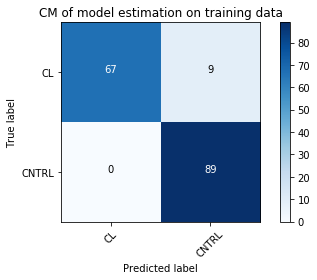


# Tuning hyper-parameters for recall

Best parameters set found on development set:

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}

Grid scores on development set:

0.500 (+/-0.000) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.500 (+/-0.000) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.500 (+/-0.000) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.500 (+/-0.000) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.475 (+/-0.295) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.500 (+/-0.000) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.628 (+/-0.357) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.475 (+/-0.295) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.589 (+/-0.356) for {'C': 1, 'kernel': 'linear'}
0.604 (+/-0.343) for {'C': 10, 'kernel': 'linear'}
0.600 (+/-0.424) for {'C': 20, 'kernel': 'linear'}
0.578 (+/-0.443) for {'C': 100, 'kernel': 'linear'}
0.500 (+/-0.000) for {'C': 1, 'kernel': 'sigmoid'}
0.500 (+/-0.000) for {'C': 10, 'kernel': 'sigmoid'}
0.491 (+

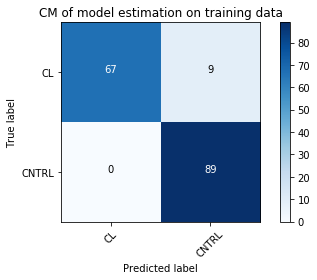

In [48]:
'''
Support Vector Classification with GridSearch 
Parameters will be set by cross-validation (GridSearchCV)
: Training features = smoothed spectra
''' 

tuned_parameters = [
    {'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],'C': [1, 10, 100, 1000]},
    {'kernel': ['linear'], 'C': [1, 10, 20,100]},
    {'kernel': ['sigmoid'], 'C': [1, 10, 100, 1000]}
    ]

scores = ['precision', 'recall']
classes = ['CL', 'CNTRL']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(X_train_sm, y_train_label)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    
    # evaluate model on same training set
    y_true, y_pred = y_train_label, clf.predict(X_train_sm)
    
    print(classification_report(y_true, y_pred,target_names = classes))
    cm = confusion_matrix(y_true, y_pred)
    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cm, classes=classes,# normalize=True
                          title='CM of model estimation on training data')
    plt.show()
    print()


In [49]:
# Build model using optimal parameters
clf = SVC(C=1000,gamma=0.001,kernel='rbf')#SVC(C=10, kernel='linear')#
#clf = SVC(C=10, kernel='linear')#
clf.fit(X_train_sm, y_train_label)

# evaluate model on same training set
y_true, y_pred = y_train_label, clf.predict(X_train_sm)
y_true = pd.DataFrame(data=y_true)
y_pred = pd.DataFrame(data=y_pred)
svm_calib_output = pd.concat([y_true, y_pred], axis=1)
#svm_calib_output.head(3)
#export 'svm_calib_output_cl-cntrl' to csv
print('ROC_AUC = %.2f ' %(roc_auc_score(y_train_label, y_pred)))

ROC_AUC = 0.94 


              precision    recall  f1-score   support

          CL       0.75      0.86      0.80        21
       CNTRL       0.84      0.73      0.78        22

   micro avg       0.79      0.79      0.79        43
   macro avg       0.80      0.79      0.79        43
weighted avg       0.80      0.79      0.79        43

Confusion matrix, without normalization
[[18  3]
 [ 6 16]]


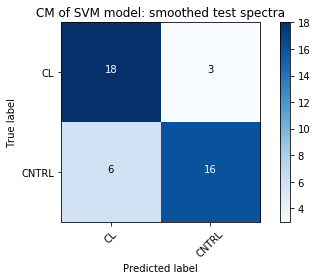

ROC_AUC = 0.79, kappa = 0.58


In [50]:
# evaluate model on test set
y_true, y_pred = y_test_label, clf.predict(X_test_sm)
print(classification_report(y_true, y_pred,target_names = classes))
    
cm = confusion_matrix(y_true, y_pred)
fig = plt.figure()
plot_confusion_matrix(cm, classes=classes,# normalize=True
                      title='CM of SVM model: smoothed test spectra')
plt.show()
fig.savefig('figs/CM_svm_cl-cntrl_9_2_sm.eps', format='eps', dpi=300)

y_true = pd.DataFrame(data=y_true)
y_pred = pd.DataFrame(data=y_pred)
svm_test_output = pd.concat([y_true, y_pred], axis=1)
#svm_test_output.head()
#export 'svm_test_output_cl-cntrl' to csv
print('ROC_AUC = %.2f, kappa = %.2f' %(roc_auc_score(y_test_label, y_pred), 
                                   cohen_kappa_score(y_test_label, y_pred)))

### What spectral variables (features) are most important in the classifier?

In [33]:
coef = clf.coef_[0]
#coef.shape
coef_sc = coef/np.max(coef)

(140,)

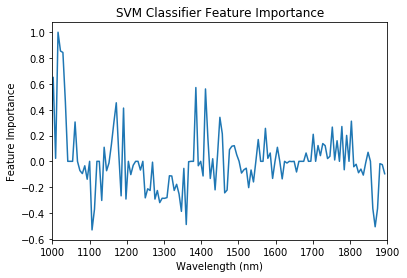

In [52]:
fig = plt.figure()
plt.plot(wave_trim,coef_sc)
    
plt.xlim(right=1900, left=1000)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Feature Importance')
plt.title('SVM Classifier Feature Importance')
plt.show()

#fig.savefig('figs/FeatImp_svm_cl-cntrl_9_2_sm2.png', format='png', dpi=600)

#### Using latent variables
 
Latent variables, based on principal component analysis, will now be used instead of the actual variables

In [107]:
# Fit to data and predict using pipelined scaling and PCA (with 8 components).
std_clf = make_pipeline(StandardScaler(), PCA(n_components=8))
std_clf.fit(X_train_sm)

# Extract PCA from pipeline
pca_std = std_clf.named_steps['pca']

# 1st PCA axis (basically, loadings directions)
#X_train_sm_ax = pca_std.components[0]
#print('\nPC 1 with scaling:\n', X_train_sm_ax)

# Scale and use PCA on train and test features 
scaler = std_clf.named_steps['standardscaler']
X_train_sm_sc = pca_std.transform(scaler.transform(X_train_sm))
X_test_sm_sc = pca_std.transform(scaler.transform(X_test_sm))

print(X_train_sm_sc.shape, X_test_sm_sc.shape)

(495, 8) (129, 8)


In [108]:
print(pca_std.components_.shape)
print(X_train_sm.shape)
pca_std.explained_variance_ratio_


(8, 140)
(495, 140)


array([0.83521967, 0.08321027, 0.0181383 , 0.0118913 , 0.00586357,
       0.00559247, 0.00446715, 0.00369586])

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}

Grid scores on development set:

0.338 (+/-0.180) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.270 (+/-0.002) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.656 (+/-0.386) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.409 (+/-0.394) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.671 (+/-0.392) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.591 (+/-0.495) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.655 (+/-0.340) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.665 (+/-0.458) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.653 (+/-0.413) for {'C': 1, 'kernel': 'linear'}
0.648 (+/-0.408) for {'C': 10, 'kernel': 'linear'}
0.648 (+/-0.408) for {'C': 20, 'kernel': 'linear'}
0.650 (+/-0.416) for {'C': 100, 'kernel': 'linear'}
0.509 (+/-0.074) for {'C': 1, 'kernel': 'sigmoid'}
0.504 (+/-0.064) for {'C': 10, 'kernel': 'sigmoid'}
0.507 (

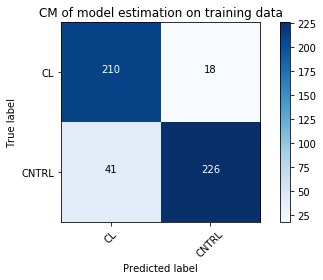


# Tuning hyper-parameters for recall

Best parameters set found on development set:

{'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}

Grid scores on development set:

0.441 (+/-0.152) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.500 (+/-0.000) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.656 (+/-0.374) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.411 (+/-0.215) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.672 (+/-0.385) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.598 (+/-0.457) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.651 (+/-0.334) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.674 (+/-0.432) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.653 (+/-0.395) for {'C': 1, 'kernel': 'linear'}
0.645 (+/-0.390) for {'C': 10, 'kernel': 'linear'}
0.645 (+/-0.390) for {'C': 20, 'kernel': 'linear'}
0.647 (+/-0.398) for {'C': 100, 'kernel': 'linear'}
0.509 (+/-0.073) for {'C': 1, 'kernel': 'sigmoid'}
0.504 (+/-0.063) for {'C': 10, 'kernel': 'sigmoid'}
0.507 (

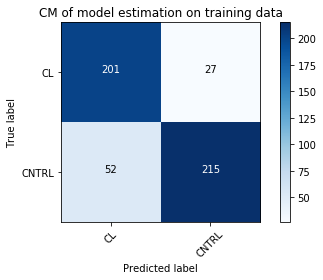

In [109]:
'''
Support Vector Classification with GridSearch on latent variables based on 
PCA score with standardization.
Parameters will be set by cross-validation (GridSearchCV)
''' 
tuned_parameters = [
    {'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],'C': [1, 10, 100, 1000]},
    {'kernel': ['linear'], 'C': [1, 10, 20,100]},
    {'kernel': ['sigmoid'], 'C': [1, 10, 100, 1000]}
    ]

scores = ['precision', 'recall']
classes = ['CL', 'CNTRL']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(X_train_sm_sc, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    # evaluate model on same training set
    y_true, y_pred = y_train, clf.predict(X_train_sm_sc)
    print(classification_report(y_true, y_pred,target_names = classes))
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure()
    plot_confusion_matrix(cm, classes=classes,# normalize=True
                          title='CM of model estimation on training data')
    plt.show()
    print()


In [110]:
# Build model using optimal parameters
clf = SVC(C=100,gamma=0.001, kernel='rbf') #'C': 100, 'gamma': 0.001, 'kernel': 'rbf'
clf.fit(X_train_sm_sc, y_train_label)

# evaluate model on same training set
y_true, y_pred = y_train_label, clf.predict(X_train_sm_sc)
y_true = pd.DataFrame(data=y_true)
y_pred = pd.DataFrame(data=y_pred)
svm_calib_output = pd.concat([y_true, y_pred], axis=1)
#svm_calib_output.head(3)
#export 'svm_calib_output_cl-cntrl' to csv
print('ROC_AUC = %.2f ' %(roc_auc_score(y_train_label, y_pred)))

ROC_AUC = 0.88 


              precision    recall  f1-score   support

          CL       0.51      0.56      0.53        63
       CNTRL       0.53      0.48      0.51        66

   micro avg       0.52      0.52      0.52       129
   macro avg       0.52      0.52      0.52       129
weighted avg       0.52      0.52      0.52       129

Confusion matrix, without normalization
[[35 28]
 [34 32]]


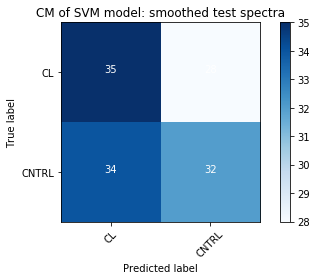

ROC_AUC = 0.52 


In [111]:
# evaluate model on test set
y_true, y_pred = y_test_label, clf.predict(X_test_sm_sc)
print(classification_report(y_true, y_pred,target_names = classes))
    
cm = confusion_matrix(y_true, y_pred)
fig = plt.figure()
plot_confusion_matrix(cm, classes=classes,# normalize=True
                      title='CM of SVM model: smoothed test spectra')
plt.show()
fig.savefig('figs/CM_svm_cl-cntrl_9_2_sm.eps', format='eps', dpi=300)

y_true = pd.DataFrame(data=y_true)
y_pred = pd.DataFrame(data=y_pred)
svm_test_output = pd.concat([y_true, y_pred], axis=1)
#svm_test_output.head()
#export 'svm_test_output_cl-cntrl' to csv
print('ROC_AUC = %.2f ' %(roc_auc_score(y_test_label, y_pred)))

SV Classifier is apparently not doing well with latent variables.

## 2. Logistic Regression

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 1000, 'penalty': 'l1'}

Grid scores on development set:

0.230 (+/-0.007) for {'C': 0.001, 'penalty': 'l1'}
0.270 (+/-0.007) for {'C': 0.001, 'penalty': 'l2'}
0.230 (+/-0.007) for {'C': 0.01, 'penalty': 'l1'}
0.270 (+/-0.007) for {'C': 0.01, 'penalty': 'l2'}
0.270 (+/-0.007) for {'C': 0.1, 'penalty': 'l1'}
0.508 (+/-0.495) for {'C': 0.1, 'penalty': 'l2'}
0.612 (+/-0.263) for {'C': 1, 'penalty': 'l1'}
0.573 (+/-0.478) for {'C': 1, 'penalty': 'l2'}
0.566 (+/-0.439) for {'C': 10, 'penalty': 'l1'}
0.614 (+/-0.536) for {'C': 10, 'penalty': 'l2'}
0.631 (+/-0.464) for {'C': 100, 'penalty': 'l1'}
0.615 (+/-0.540) for {'C': 100, 'penalty': 'l2'}
0.651 (+/-0.498) for {'C': 1000, 'penalty': 'l1'}
0.639 (+/-0.511) for {'C': 1000, 'penalty': 'l2'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision 

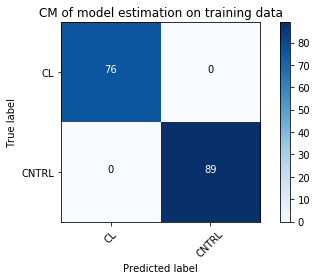


# Tuning hyper-parameters for recall

Best parameters set found on development set:

{'C': 1000, 'penalty': 'l1'}

Grid scores on development set:

0.500 (+/-0.000) for {'C': 0.001, 'penalty': 'l1'}
0.500 (+/-0.000) for {'C': 0.001, 'penalty': 'l2'}
0.500 (+/-0.000) for {'C': 0.01, 'penalty': 'l1'}
0.500 (+/-0.000) for {'C': 0.01, 'penalty': 'l2'}
0.500 (+/-0.000) for {'C': 0.1, 'penalty': 'l1'}
0.458 (+/-0.275) for {'C': 0.1, 'penalty': 'l2'}
0.570 (+/-0.182) for {'C': 1, 'penalty': 'l1'}
0.558 (+/-0.439) for {'C': 1, 'penalty': 'l2'}
0.555 (+/-0.409) for {'C': 10, 'penalty': 'l1'}
0.607 (+/-0.516) for {'C': 10, 'penalty': 'l2'}
0.596 (+/-0.417) for {'C': 100, 'penalty': 'l1'}
0.604 (+/-0.520) for {'C': 100, 'penalty': 'l2'}
0.628 (+/-0.465) for {'C': 1000, 'penalty': 'l1'}
0.622 (+/-0.478) for {'C': 1000, 'penalty': 'l2'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision   

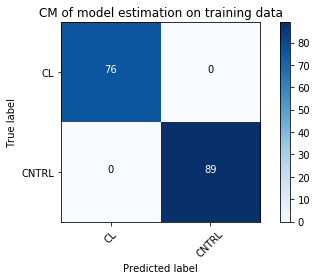

In [53]:
'''
Logistic Regression with parameters set by cross-validation (GridSearchCV)
''' 
tuned_parameters = [{'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100,1000]}]

scores = ['precision', 'recall']
classes = ['CL', 'CNTRL']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(LogisticRegression(random_state=0), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(X_train_sm, y_train_label)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    # evaluate model on same training set
    y_true, y_pred = y_train_label, clf.predict(X_train_sm)
    print(classification_report(y_true, y_pred,target_names = classes))
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure()
    plot_confusion_matrix(cm, classes=classes,# normalize=True
                          title='CM of model estimation on training data')
    plt.show()
    print()


In [54]:
# Re-train classifier using the optimal parameters
clf = LogisticRegression(C=1000, penalty='l1',random_state=0)
clf.fit(X_train_sm, y_train_label)

# evaluate model on (same) training set
y_true, y_pred = y_train_label, clf.predict(X_train_sm)
y_true = pd.DataFrame(data=y_true)
y_pred = pd.DataFrame(data=y_pred)
logreg_calib_output = pd.concat([y_true, y_pred], axis=1)
logreg_calib_output.head(5)
#export 'logreg_calib_output_cl-cntrl' to csv
print('ROC_AUC = %.2f ' %(roc_auc_score(y_train_label, y_pred)))

ROC_AUC = 1.00 


              precision    recall  f1-score   support

          CL       0.90      0.90      0.90        21
       CNTRL       0.91      0.91      0.91        22

   micro avg       0.91      0.91      0.91        43
   macro avg       0.91      0.91      0.91        43
weighted avg       0.91      0.91      0.91        43

Confusion matrix, without normalization
[[19  2]
 [ 2 20]]


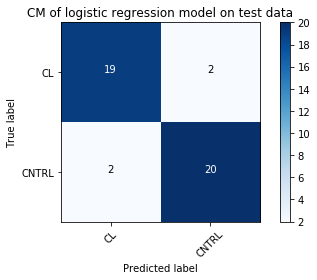

ROC_AUC = 0.91, kappa = 0.81


In [43]:
# evaluate model on test set
y_true, y_pred = y_test_label, clf.predict(X_test_sm)
print(classification_report(y_true, y_pred,target_names = classes))
    
cm = confusion_matrix(y_true, y_pred)
fig = plt.figure()
plot_confusion_matrix(cm, classes=classes,# normalize=True
                      title='CM of logistic regression model on test data')
plt.show()
fig.savefig('figs/CM_lr_cl-cntrl_9_2_sm.eps', format='eps', dpi=300)

y_true = pd.DataFrame(data=y_true)
y_pred = pd.DataFrame(data=y_pred)
logreg_test_output = pd.concat([y_true, y_pred], axis=1)
#logreg_test_output.head()
#export 'logreg_calib_output_cl-cntrl' to csv
print('ROC_AUC = %.2f, kappa = %.2f' %(roc_auc_score(y_test_label, y_pred), 
                                   cohen_kappa_score(y_test_label, y_pred)))

Logistic Regression is showing better test performance than Support Vectors.

### What spectral variables (features) are most important in the LR classifier?

In [46]:
coef = clf.coef_[0]
#coef.shape
coef_sc = coef/np.max(coef)

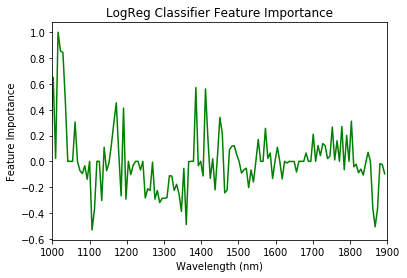

In [47]:
fig = plt.figure()
plt.plot(wave_trim,coef_sc,'g')
    
plt.xlim(right=1900, left=1000)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Feature Importance')
plt.title('LogReg Classifier Feature Importance')
plt.show()

#fig.savefig('figs/FeatImp_lr_cl-cntrl_9_2_sm2.png', format='png', dpi=600)

## 3. Deep learning Classifier

A deep fully connected network (`FCN` with `4`-hidden layers) was trained in **keras**, with tensorflow backend.

In [27]:
# Run this on apple MBP-2018
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'


In [29]:
# One-Hot encode y_train and y_test
y_train_lb = np_utils.to_categorical(y_train_label, 2)
y_test_lb = np_utils.to_categorical(y_test_label, 2)

nb_class = 2
nfeat = 140

In [30]:
# define network architecture for smoothed spectra
K.clear_session()
model = Sequential()
model.add(Dense(70, input_dim=nfeat, activation="tanh",kernel_initializer="glorot_uniform"))
model.add(Dense(70, activation="tanh"))
model.add(Dense(35, activation="tanh"))
model.add(Dense(14, activation="tanh"))
model.add(Dropout(0.4))
model.add(Dense(nb_class))
model.add(Activation("softmax"))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 70)                9870      
_________________________________________________________________
dense_2 (Dense)              (None, 70)                4970      
_________________________________________________________________
dense_3 (Dense)              (None, 35)                2485      
_________________________________________________________________
dense_4 (Dense)              (None, 14)                504       
_________________________________________________________________
dropout_1 (Dropout)          (None, 14)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 30        
_________________________________________________________________
activation_1 (Activation)    (None, 2)                 0         
Total para


Epoch 00001: val_loss improved from inf to 0.37317, saving model to weights.hdf5

Epoch 00002: val_loss did not improve from 0.37317

Epoch 00003: val_loss did not improve from 0.37317

Epoch 00004: val_loss did not improve from 0.37317

Epoch 00005: val_loss improved from 0.37317 to 0.36741, saving model to weights.hdf5

Epoch 00006: val_loss did not improve from 0.36741

Epoch 00007: val_loss improved from 0.36741 to 0.34785, saving model to weights.hdf5

Epoch 00008: val_loss did not improve from 0.34785

Epoch 00009: val_loss did not improve from 0.34785

Epoch 00010: val_loss did not improve from 0.34785

Epoch 00011: val_loss did not improve from 0.34785

Epoch 00012: val_loss did not improve from 0.34785

Epoch 00013: val_loss did not improve from 0.34785

Epoch 00014: val_loss did not improve from 0.34785

Epoch 00015: val_loss did not improve from 0.34785

Epoch 00016: val_loss did not improve from 0.34785

Epoch 00017: val_loss did not improve from 0.34785

Epoch 00018: val_

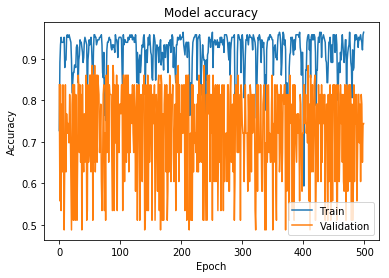

In [65]:

#model = load_model("best_dnn_nir_cl-cntrl_model.hdf5")

tboard = TensorBoard(log_dir='logs/{}'.format(time()))
checkpointer = ModelCheckpoint(filepath="best_dnn_nir_cl-cntrl_model.hdf5.hdf5", verbose=1, save_best_only=True)

nb_epoch=500
adam = Adam(lr=0.0005)# sgd = SGD(lr=0.001)
model.compile(loss="binary_crossentropy", optimizer=adam, metrics=['acc'])
hist = model.fit(X_train_sm, y_train_lb, 
                 epochs=nb_epoch, validation_data=(X_test_sm, y_test_lb),#validation_split=1/10,
                 batch_size=32, verbose=0,callbacks=[tboard, checkpointer])

# Plot training & validation accuracy values
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()


              precision    recall  f1-score   support

          CL       0.89      0.76      0.82        21
       CNTRL       0.80      0.91      0.85        22

   micro avg       0.84      0.84      0.84        43
   macro avg       0.84      0.84      0.84        43
weighted avg       0.84      0.84      0.84        43

Confusion matrix, without normalization
[[16  5]
 [ 2 20]]


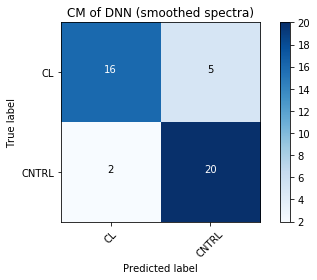

ROC_AUC = 0.84, kappa = 0.67


In [68]:
model = load_model('best_dnn_nir_cl-cntrl_model.hdf5')

prediction = []
for x in range(len(X_test_sm)):
    probs = model.predict(X_test_sm)[x]
    prediction.append(probs.argmax(axis=0))

#print('Probabilities:',probs)
#print('Prediction:',prediction)
#prediction

# evaluate model on test set
classes = ['CL', 'CNTRL']
y_true, y_pred = y_test_label, prediction
print(classification_report(y_true, y_pred,target_names = classes))
    
cm = confusion_matrix(y_true, y_pred)
fig = plt.figure()
plot_confusion_matrix(cm, classes=classes,# normalize=True
                      title='CM of DNN (smoothed spectra)')
plt.show()
#fig.savefig('figs/CM_dnn_cl-cntrl_9_2_sm.eps', format='eps', dpi=300)

y_true = pd.DataFrame(data=y_true)
y_pred = pd.DataFrame(data=y_pred)
logreg_test_output = pd.concat([y_true, y_pred], axis=1)
#logreg_test_output.head()
#export 'logreg_calib_output_aclt-cntrl' to csv

print('ROC_AUC = %.2f, kappa = %.2f' %(roc_auc_score(y_test_label, y_pred), 
                                   cohen_kappa_score(y_test_label, y_pred)))